In [1]:
import torch
from pytorch_pretrained_gans import make_gan
import numpy as np
from modeling.models.bethge import BethgeModel
from skimage.draw import disk
from torchvision.transforms import CenterCrop,Resize
from visualization_utils.optimizer import GANOptimzier
from visualization_utils.losses import *
from visualization_utils.utils import torch_rand_range
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
def visualize_gan(network, gan,shape=128,
              init_range=(-1, 1), max_iter=400, lr=np.linspace(1, 0.5, 100),
              min_loss_val=None, target=None, debug=False):
    """
    Returns:

    optimized image
    loss for the last iteration
    """
    # partial application, since the index can't be passed in optimizer code

    loss_func = output_loss
    optimizer = GANOptimzier(gan, network, loss_func)

    if min_loss_val is not None:
        early_stopper = lambda losses: losses[-1] < min_loss_val
    else:
        early_stopper = None

    # now start optimization
    rand_vector = torch_rand_range((1,128), init_range).cuda()
    return optimizer.optimize(rand_vector, target, max_iter=max_iter,
                              lr=lr, debug=debug, early_stopper=early_stopper)
def partial_grating(img, center, radius, gray=0.5,
        background=None):
    """
    put an aperture over a sine-wave grating image
    """
    # outside aperture will be gray
    # unless it's something like a diff orientation
    if background is None:
        new_img = torch.full(img.shape, fill_value=gray).to('cuda')
    else:
        new_img = background

    # copy the corresponding circle of grating onto it
    rr, cc = disk((center[0], center[1]), radius, shape=img.shape)
    new_img[rr, cc] = img[rr, cc]
    return new_img

def image_transform(img):
    x = img[0]
    x = (x+1)/2
    x = x[0] * 299/1000 + x[1] * 587/1000 + x[2] * 114/1000
    x = CenterCrop(128)(x)
    x = torch.reshape(x, (1,128,128))
    x = Resize(50,antialias=True)(x)[0]
    x = partial_grating(x, (25,25), 25, gray=0.0)
    return x

def visualize_vector(net, G, target, input_size):
    # if multiple models are considered, then load each model one by one. Each neuron is contained in one folder, with
    # pictures equal to the number of models


    return vector



In [2]:
site = 'm2s1'
num_neurons = 299
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
channels = 256
num_layers = 9
input_size = 50
output_size = num_neurons
first_k = 9
later_k = 3
pool_size = 2
factorized = True
num_maps = 1
net = BethgeModel(channels=channels, num_layers=num_layers, input_size=input_size,
                  output_size=output_size, first_k=first_k, later_k=later_k,
                  input_channels=1, pool_size=pool_size, factorized=True,
                  num_maps=num_maps).cuda()
net.to(device)
net.load_state_dict(torch.load(f'../data/9_10_m2s1_shared_core_256_9'))

val_rsp = np.load('../data/valRsp_m2s1.npy')
val_img = np.load('../data/val_img_m2s1.npy')

G = make_gan(gan_type='biggan', model_name='biggan-deep-256').to('cuda')
G.eval()
net.eval()


Loading BigGAN model biggan-deep-256 from cache at C:\Users\admin\.pytorch_pretrained_biggan\e7d036ee69a83e83503c46902552573b27d856eaf6b8b84252a63a715dce7501.aec5caf3e5c5252b8857d6bb8adefa8d1d6092a8ba6c9aaed1e6678f8a46be43


BethgeModel(
  (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1), bias=False)
      (1): Softplus(beta=1, threshold=20)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): Softplus(beta=1, threshold=20)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): Softplus(beta=1, threshold=20)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): Softplus(beta=1

In [14]:
imList = []
lossList = []
for i in range(10):
    best_vector, vector, loss, best_loss = visualize_gan(net, G, shape=128,init_range=(-1, 1), max_iter=400, lr=np.linspace(0.001, 0.001, 500),target=torch.tensor(val_rsp[4]).to(device))
    img = G(z=best_vector)
    img = image_transform(img)

    x = img.detach().cpu().numpy()
    x = x*255
    a = Image.fromarray(x.astype('uint8'))
    imList.append(a)
    lossList.append(loss)


F:\Repos\CNN_Tang_project\visualization_utils\optimizer.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_input = torch.tensor(input, requires_grad=True)


torch.Size([1, 128])


100%|██████████| 400/400 [00:34<00:00, 11.62it/s]


torch.Size([1, 128])


100%|██████████| 400/400 [00:34<00:00, 11.63it/s]


torch.Size([1, 128])


100%|██████████| 400/400 [00:34<00:00, 11.62it/s]


torch.Size([1, 128])


100%|██████████| 400/400 [00:34<00:00, 11.61it/s]


torch.Size([1, 128])


100%|██████████| 400/400 [00:34<00:00, 11.62it/s]


torch.Size([1, 128])


100%|██████████| 400/400 [00:34<00:00, 11.60it/s]


torch.Size([1, 128])


100%|██████████| 400/400 [00:34<00:00, 11.56it/s]


torch.Size([1, 128])


100%|██████████| 400/400 [00:34<00:00, 11.55it/s]


torch.Size([1, 128])


100%|██████████| 400/400 [00:34<00:00, 11.59it/s]


torch.Size([1, 128])


100%|██████████| 400/400 [00:34<00:00, 11.61it/s]


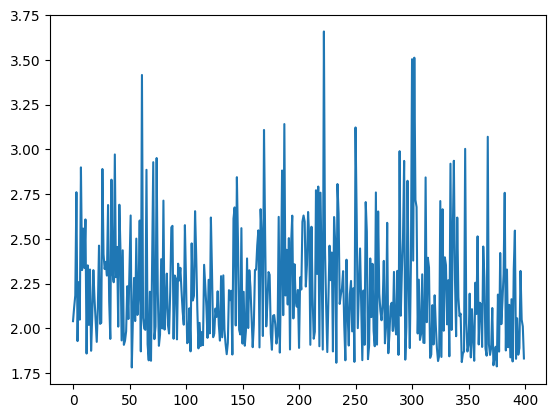

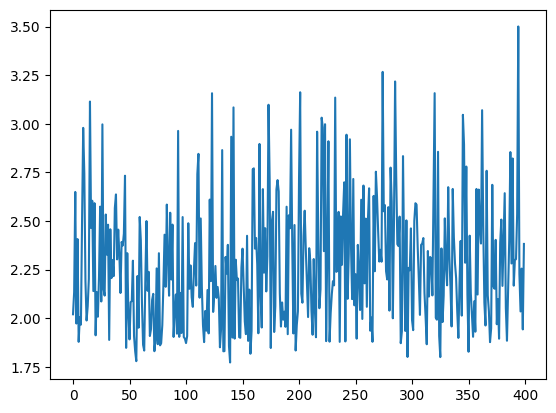

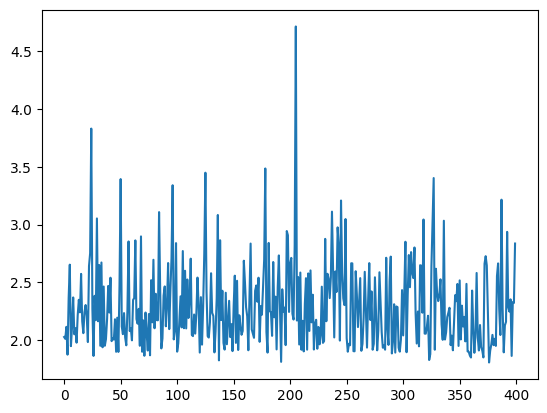

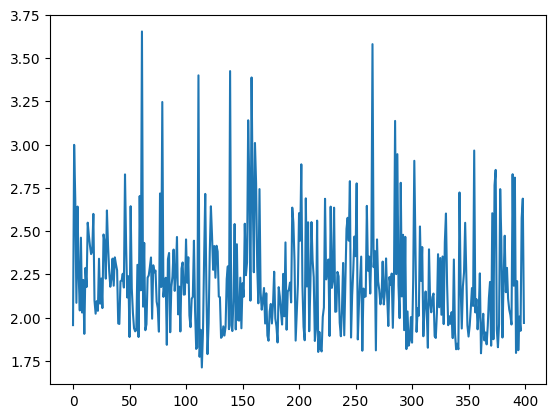

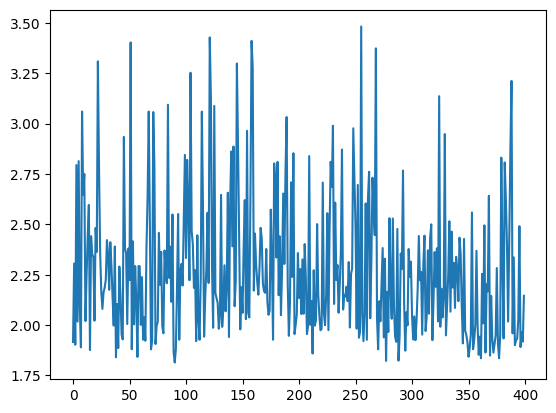

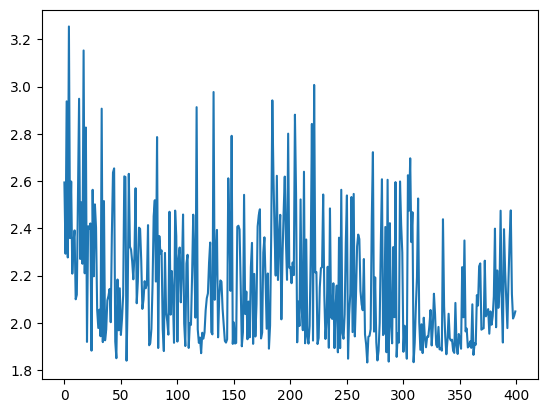

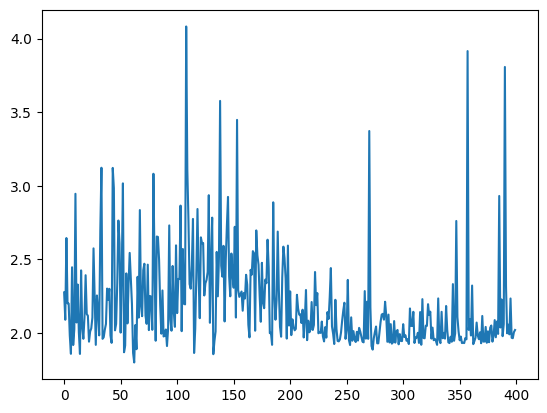

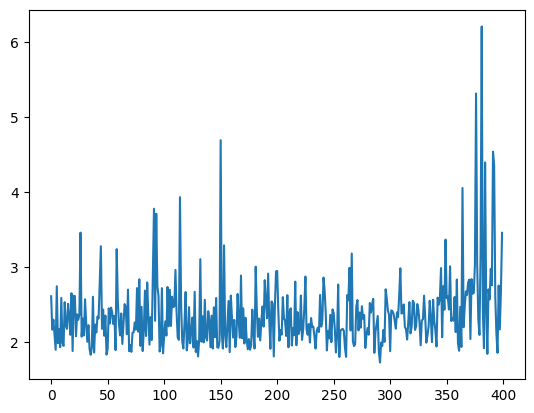

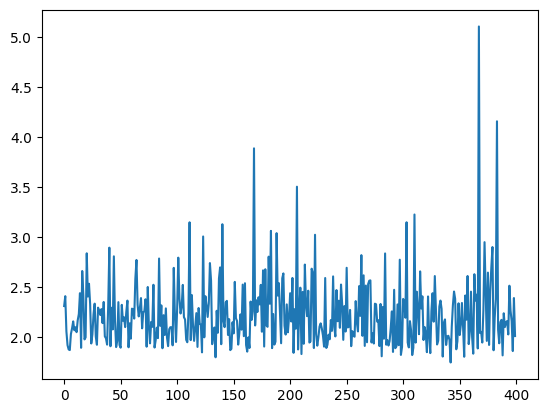

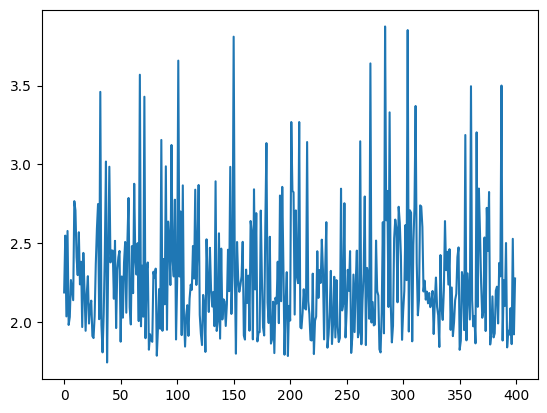

In [15]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.figure()
    plt.plot(lossList[i])


In [16]:
for i, im in enumerate(imList):
    im.save(f'recon_results_3/{np.min(lossList[i])}.jpg')

In [10]:
y = np.reshape(val_img[4], (50,50))*255
b = Image.fromarray(y.astype('uint8'))
b.show()

In [44]:
z = G.sample_latent(batch_size=1,  device='cuda')
img = G(z=z)
img = image_transform(img)
from PIL import Image
x = img.detach().cpu().numpy()
x = x*255
a = Image.fromarray(x.astype('uint8'))
a.show()

In [53]:
z[0,0] = z[0,1] + 0.0000001
img = G(z=z)
img = image_transform(img)
from PIL import Image
x = img.detach().cpu().numpy()
x = x*255
a = Image.fromarray(x.astype('uint8'))
a.show()

In [4]:
G = make_gan(gan_type='stylegan2').to('cuda')  # -> nn.Module


Downloading: "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl" to C:\Users\admin/.cache\torch\hub\checkpoints\ffhq.pkl


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\admin\\.cache\\torch\\hub\\checkpoints\\tmp4p92okr9'